<table width = "100%">
  <tr style="background-color:white;">
    <!-- QWorld Logo -->
    <td style="text-align:left;width:200px;"> 
        <a href="https://qworld.net/" target="_blank"><img src="../images/QWorld.png"> </a></td>
    <td style="text-align:right;vertical-align:bottom;font-size:16px;"> 
        Prepared by Özlem Salehi</td>    
</table>
<hr>

# <font color="blue"> Solutions for </font> BQM for the Graph Coloring Problem

### Imports

In [1]:
from collections import defaultdict

import dimod
from dimod import BQM
import dwave_networkx as dnx
from neal import SimulatedAnnealingSampler
import networkx as nx

from bqm_utils import graph_viz, graph_coloring_viz

<a id="Task1"></a>
### Task 1

Add the first constraint to the BQM.

### Solution

For completeness, let us add the necessary code to create the graph and bqm as well.

In [4]:
G = nx.Graph()
edges = [(0, 1), (0,4), (1,2), (1,3), (1,4), (2,3), (3,4)]
G.add_edges_from(edges)

In [5]:
bqm = BQM('BINARY')

Here is the code to add the first constraint. 

In [7]:
N = len(G.nodes)
colors = [0,1,2]
for i in range(N):
    c1 = [(f"x_{i}_{c}", 1) for c in colors]
    bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=1)

<a id="Task2"></a>
### Task 2

Write a Python function named `is_sample_feasible` that takes as parameter a sample containing binary variables named `x_i_c` and their values, the list of colors, the list of edges, and the number of nodes and returns True if the sample corresponds to a feasible coloring and false otherwise.

### Solution

In [8]:
def is_sample_feasible(sample, colors, edges, N):
    for i, j in edges:
        for c in colors:
            if sample[f"x_{i}_{c}"] == 1 and sample[f"x_{j}_{c}"] == 1:
                return False        
    for i in range(N):
        if sum(sample[f"x_{i}_{c}"] for c in colors) != 1:
            return False
    return True

<a id="Task3"></a>
### Task 3

Write a function named `sample_to_coloring` that takes as parameter a sample containing binary variables named `x_i_c` and their values, the list of colors and the number of vertices, and returns a dictionary where the keys are the nodes and the values are the colors.

### Solution

In [9]:
def sample_to_coloring(sample, colors, N):
    coloring = {}
    for i in range(N):
        for c in colors:
            if sample[f"x_{i}_{c}"] == 1:
                coloring[i] = c
    return coloring

<a id="Task4"></a>
### Task 4

Create a function named `graph_coloring_bqm` that takes as input the list of colors, the list of edges, number of vertices and returns the binary quadratic model for the graph coloring problem


### Solution

In [10]:
def graph_coloring_bqm(colors, edges, N):
    bqm = BQM("BINARY")
    for i in range(N):
        c1 = [(f"x_{i}_{c}", 1) for c in colors]
        bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=1)
    for c in colors:
        for i, j in edges:
            c2 = [(f"x_{i}_{c}", 1), (f"x_{j}_{c}", 1)]
            bqm.add_linear_inequality_constraint(
                c2, lagrange_multiplier=1, ub=1, label=f"c2_{i}_{j}_{c}"
            )
    return bqm

<a id="Task5"></a>
### Task 5

Using the function you have created in Task 4, try coloring the same graph using two colors only and interpret the result.


### Solution

In [11]:
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (3, 4)]
G = nx.Graph()
G.add_edges_from(edges)

# Create list of colors
colors = [0, 1]

# Create bqm
N = len(G.nodes)
bqm = graph_coloring_bqm(colors, edges, N)

# Solve BQM
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)

In [12]:
# Check feasbility of the first sample
first_sample = sampleset.first.sample
is_sample_feasible(first_sample, colors, G.edges, N)

False

We see that the first sample is not feasible. We can check if any feasible sample exists using the `best_solution function.`

In [13]:
def best_solution(sampleset, colors, edges, N):
    for sample, energy in sampleset.data(fields=["sample", "energy"]):
        if is_sample_feasible(sample, colors, edges, N):
            return sample, energy
    return None, None

In [14]:
sample, energy = best_solution(sampleset, colors, G.edges, N)
print(sample)

None


We see that no feasible solution exists.

Let us print the coloring corresponding to the first sample.

In [15]:
coloring = sample_to_coloring(first_sample, colors, N)
print(coloring)

{0: 1, 2: 0, 3: 1, 4: 0}


We observe that one of the nodes is not colored. We can go further and visualize the result.

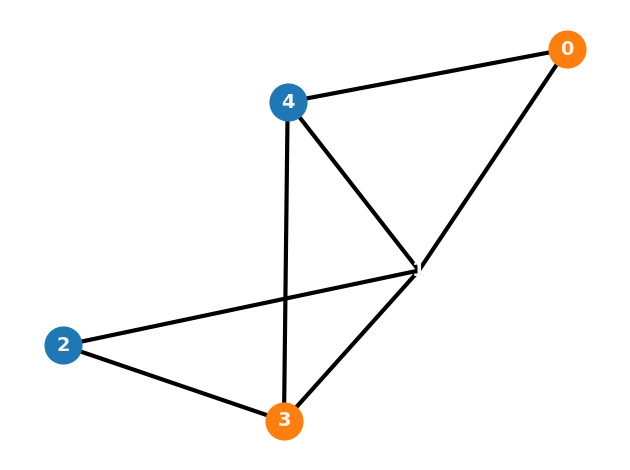

In [16]:
graph_coloring_viz(G, coloring)

<a id="Task6"></a>
### Task 6

For the Petersen graph displayed below, determine the minimum number of colors needed to properly color the graph.

Hint: Starting with 2 colors, increase the number of colors you use inside a loop until a feasible coloring is found.

### Solution

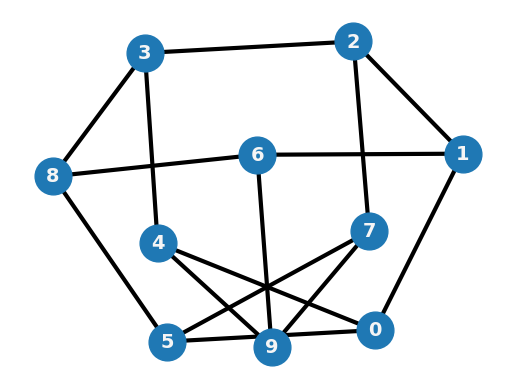

In [17]:
Gp = nx.petersen_graph()
graph_viz(Gp)

{0: 1, 1: 0, 2: 2, 3: 1, 4: 2, 5: 2, 6: 1, 7: 1, 8: 0, 9: 0}
3  colors are used


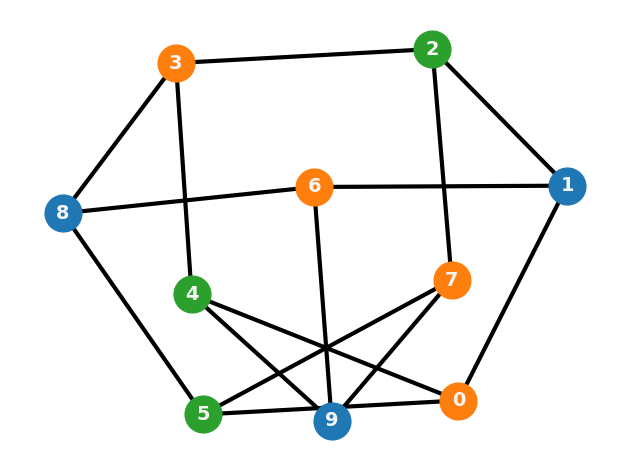

In [18]:
sampler = SimulatedAnnealingSampler()
edges = Gp.edges
N = len(Gp.nodes)
for k in list(range(2, 10)):
    colors = list(range(k))
    bqm = graph_coloring_bqm(colors, edges, N)
    sampleset = sampler.sample(bqm, num_reads=100)
    first_sample = sampleset.first.sample
    if is_sample_feasible(first_sample, colors, edges, N):
        break
coloring = sample_to_coloring(first_sample, colors, N)
print(coloring)
print(k, " colors are used")
graph_coloring_viz(Gp, coloring)